In [1]:
import torch
import torch.nn.functional as F
import trimesh
#from trimesh.util import triangle_strips_to_faces

from src.util import make_faces
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

torch.set_printoptions( sci_mode=False)

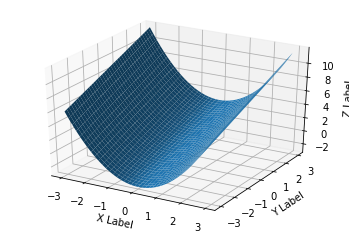

In [2]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random

def fun(x, y):
    return x**2 + y

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-3.0, 3.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array(fun(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

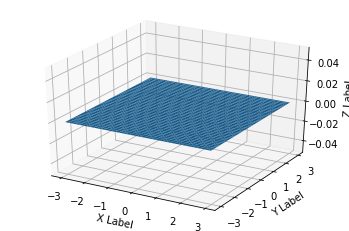

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-3.0, 3.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.zeros_like(X)
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

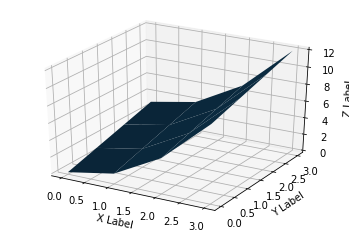

In [7]:
def fun(x, y):
    return x**2 + y

xs = ys = torch.arange(0.0, 4.0, 1)
x, y = torch.meshgrid(xs, ys)

zs = np.array(fun(np.ravel(x.numpy()), np.ravel(y.numpy())))
z = torch.tensor(zs.reshape(x.shape))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), z.numpy())

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [8]:
vertices = torch.stack((x, y, z), dim=-1).reshape(-1, 3)
print(vertices.shape)
faces = make_faces(4, 4)
print(faces.shape)
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=True)
#mesh.show();

#mesh.export('./data/curved_plane3x3_0.stl');

torch.Size([16, 3])
(18, 3)


In [49]:
import os
from collections import OrderedDict
import torch
import torch.nn.functional as F
from src.util import (
    make_faces,    
)    

def vertex_tris(faces):
    res = [[] for _ in range(faces.max()+1)]
    for fid, face in enumerate(faces):        
        for vid in face:
            res[vid].append(fid)        
    return res

def vertex_tri_maps(faces):
    vts = vertex_tris(faces)
    r, c = len(vts), max([len(x) for  x in vts])
    vert_tri_indices = torch.zeros(r, c, dtype=torch.long)
    vert_tri_weights = torch.zeros(r, c)    
    for r, tris in enumerate(vts):        
        weight = 1. #/ len(tris)
        for c, tri_id in enumerate(tris):
            vert_tri_indices[r, c] = tri_id
            vert_tri_weights[r, c] = weight
    return vert_tri_indices, vert_tri_weights.unsqueeze(dim=-1)[None]

class VertexNormals(torch.nn.Module):
    
    def __init__(self, opt, load=True):
        super().__init__()
        self.size = opt.data_patch_size
        self.path = os.path.join(opt.data_dir, 
            'trimap_{}.pth'.format(opt.data_patch_size))
        if load and os.path.exists(self.path):
            trimap = torch.load(self.path)
        else:
            trimap = self.make_trimap(opt.data_patch_size)
            torch.save(trimap, self.path)
        self.assign_trimap(trimap)
    
    def assign_trimap(self,  trimap):
        self.register_buffer('faces',  trimap['faces'])
        self.register_buffer('vert_tri_indices', trimap['vert_tri_indices'])
        self.register_buffer('vert_tri_weights', trimap['vert_tri_weights'])

    def __call__(self, vrt):
        face_normals = self.get_face_normals(vrt)
        bs = face_normals.size(0)
        r, c = self.vert_tri_indices.shape
        fn_group = face_normals.index_select(1, 
            self.vert_tri_indices.flatten()).reshape(bs, r, c, 3)
        weighted_fn_group = fn_group * self.vert_tri_weights    
        vertex_normals = weighted_fn_group.sum(dim=-2)
        return F.normalize(vertex_normals, p=2, dim=-1)
    
    def get_face_normals(self, vrt):
        faces = self.faces
        v1 = vrt.index_select(1,faces[:, 1]) - vrt.index_select(1, faces[:, 0])
        v2 = vrt.index_select(1,faces[:, 2]) - vrt.index_select(1, faces[:, 0])
        face_normals = F.normalize(v1.cross(v2), p=2, dim=-1)  # [F, 3]
        return face_normals
    
    def __repr__(self):
        return f'VertexNormals: size: {self.size} path: {self.path}'
    
    def make_trimap(self, size):
        faces = torch.tensor(make_faces(size, size))
        vert_tri_indices, vert_tri_weights = vertex_tri_maps(faces)
        return OrderedDict(OrderedDict([
          ('vert_tri_indices', vert_tri_indices),
          ('vert_tri_weights', vert_tri_weights),
          ('faces', faces),
        ]))
    
from argparse import Namespace
#from src.vertex_normals import VertexNormals


opt = Namespace()
opt.data_dir = './data/'
opt.data_patch_size = 4
print(opt)
vn = VertexNormals(opt, load=False)
print(vn)

calc_mvn = vn(vertices[None])
calc_mvn    

Namespace(data_dir='./data/', data_patch_size=4)
VertexNormals: size: 4 path: ./data/trimap_4.pth


tensor([[[-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.7071, -0.5000,  0.5000],
         [-0.7662, -0.4544,  0.4544],
         [-0.7662, -0.4544,  0.4544],
         [-0.8194, -0.4053,  0.4053],
         [-0.9266, -0.2660,  0.2660],
         [-0.9366, -0.2478,  0.2478],
         [-0.9366, -0.2478,  0.2478],
         [-0.9459, -0.2295,  0.2295],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925]]])

In [53]:
torch.allclose(m_vn[None], calc_mvn)

NameError: name 'm_vn' is not defined

In [10]:
calc_fn =  vn.get_face_normals(vertices[None])
print(calc_fn.shape)

m_fn = torch.tensor(mesh.face_normals.copy()).float()[None]
print(m_fn.shape)
m_fn

torch.allclose(calc_fn, m_fn)

torch.Size([1, 18, 3])
torch.Size([1, 18, 3])


True

In [54]:
calc_vn =  vn(vertices[None])
print(calc_vn.shape)

m_vn = torch.tensor(mesh.vertex_normals.copy()).float()[None]
print(m_vn.shape)

torch.allclose(calc_vn, m_vn)

torch.Size([1, 16, 3])
torch.Size([1, 16, 3])


False

In [56]:
print(calc_vn)
m_vn

tensor([[[-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.7071, -0.5000,  0.5000],
         [-0.7662, -0.4544,  0.4544],
         [-0.7662, -0.4544,  0.4544],
         [-0.8194, -0.4053,  0.4053],
         [-0.9266, -0.2660,  0.2660],
         [-0.9366, -0.2478,  0.2478],
         [-0.9366, -0.2478,  0.2478],
         [-0.9459, -0.2295,  0.2295],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925]]])


tensor([[[-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9219, -0.2740,  0.2740],
         [-0.9496, -0.2218,  0.2218],
         [-0.9366, -0.2478,  0.2478],
         [-0.9366, -0.2478,  0.2478],
         [-0.6891, -0.5124,  0.5124],
         [-0.8257, -0.3989,  0.3989],
         [-0.7662, -0.4544,  0.4544],
         [-0.7662, -0.4544,  0.4544]]])

In [49]:
print(faces.shape)
faces

(18, 3)


array([[ 0,  4,  1],
       [ 5,  1,  4],
       [ 1,  5,  2],
       [ 6,  2,  5],
       [ 2,  6,  3],
       [ 7,  3,  6],
       [ 4,  8,  5],
       [ 9,  5,  8],
       [ 5,  9,  6],
       [10,  6,  9],
       [ 6, 10,  7],
       [11,  7, 10],
       [ 8, 12,  9],
       [13,  9, 12],
       [ 9, 13, 10],
       [14, 10, 13],
       [10, 14, 11],
       [15, 11, 14]])

In [40]:
def vertex_tris(faces):
    res = [[] for _ in range(faces.max()+1)]
    for fid, face in enumerate(faces):        
        for vid in face:
            res[vid].append(fid)        
    return res

vertex_tris(faces)

[[0],
 [0, 1, 2],
 [2, 3, 4],
 [4, 5],
 [0, 1, 6],
 [1, 2, 3, 6, 7, 8],
 [3, 4, 5, 8, 9, 10],
 [5, 10, 11],
 [6, 7, 12],
 [7, 8, 9, 12, 13, 14],
 [9, 10, 11, 14, 15, 16],
 [11, 16, 17],
 [12, 13],
 [13, 14, 15],
 [15, 16, 17],
 [17]]

In [53]:
def vertex_tri_maps(faces):
    vts = vertex_tris(faces)
    r, c = len(vts), max([len(x) for  x in vts])
    vert_tri_indices = torch.zeros(r, c, dtype=torch.long)
    vert_tri_weights = torch.zeros(r, c)    
    for r, tris in enumerate(vts):        
        weight = 1. / len(tris)
        for c, tri_id in enumerate(tris):
            vert_tri_indices[r, c] = tri_id
            vert_tri_weights[r, c] = weight
    return vert_tri_indices, vert_tri_weights.unsqueeze(dim=-1)[None]

vert_tri_indices, vert_tri_weights = vertex_tri_maps(faces)
print(vert_tri_indices)
print(vert_tri_weights.squeeze().reshape(4, 4, 6))

tensor([[ 0,  0,  0,  0,  0,  0],
        [ 0,  1,  2,  0,  0,  0],
        [ 2,  3,  4,  0,  0,  0],
        [ 4,  5,  0,  0,  0,  0],
        [ 0,  1,  6,  0,  0,  0],
        [ 1,  2,  3,  6,  7,  8],
        [ 3,  4,  5,  8,  9, 10],
        [ 5, 10, 11,  0,  0,  0],
        [ 6,  7, 12,  0,  0,  0],
        [ 7,  8,  9, 12, 13, 14],
        [ 9, 10, 11, 14, 15, 16],
        [11, 16, 17,  0,  0,  0],
        [12, 13,  0,  0,  0,  0],
        [13, 14, 15,  0,  0,  0],
        [15, 16, 17,  0,  0,  0],
        [17,  0,  0,  0,  0,  0]])
tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000],
         [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
         [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
         [0.3333, 0.3333, 0.3333, 0.0000

In [45]:
(calc_vn - m_vn).reshape(4, 4, 3)

tensor([[[    -0.0000,     -0.0000,      0.0000],
         [    -0.0000,     -0.0000,      0.0000],
         [    -0.0000,     -0.0000,      0.0000],
         [    -0.0000,     -0.0000,      0.0000]],

        [[     0.2552,     -0.3076,      0.3076],
         [     0.1961,     -0.2620,      0.2620],
         [     0.1961,     -0.2620,      0.2620],
         [     0.1428,     -0.2129,      0.2129]],

        [[    -0.0047,      0.0081,     -0.0081],
         [     0.0130,     -0.0261,      0.0261],
         [     0.0000,     -0.0000,      0.0000],
         [    -0.0093,      0.0183,     -0.0183]],

        [[    -0.2731,      0.3200,     -0.3200],
         [    -0.1366,      0.2065,     -0.2065],
         [    -0.1961,      0.2620,     -0.2620],
         [    -0.1961,      0.2620,     -0.2620]]])

In [48]:
calc_vn.shape, m_vn.shape

(torch.Size([1, 16, 3]), torch.Size([1, 16, 3]))

In [57]:
vertices

tensor([[ 0.,  0.,  0.],
        [ 0.,  1.,  1.],
        [ 0.,  2.,  2.],
        [ 0.,  3.,  3.],
        [ 1.,  0.,  1.],
        [ 1.,  1.,  2.],
        [ 1.,  2.,  3.],
        [ 1.,  3.,  4.],
        [ 2.,  0.,  4.],
        [ 2.,  1.,  5.],
        [ 2.,  2.,  6.],
        [ 2.,  3.,  7.],
        [ 3.,  0.,  9.],
        [ 3.,  1., 10.],
        [ 3.,  2., 11.],
        [ 3.,  3., 12.]])

In [58]:
mesh.vertices

TrackedArray([[ 0.,  0.,  0.],
              [ 0.,  3.,  3.],
              [ 0.,  2.,  2.],
              [ 0.,  1.,  1.],
              [ 3.,  0.,  9.],
              [ 3.,  3., 12.],
              [ 3.,  2., 11.],
              [ 3.,  1., 10.],
              [ 2.,  0.,  4.],
              [ 2.,  3.,  7.],
              [ 2.,  2.,  6.],
              [ 2.,  1.,  5.],
              [ 1.,  0.,  1.],
              [ 1.,  3.,  4.],
              [ 1.,  2.,  3.],
              [ 1.,  1.,  2.]])

In [83]:
calc_fn

tensor([[[-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925]]])

In [84]:
face_normals.flip([1])

tensor([[[-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774]]])

In [94]:
self = vn
vrt = vertices[None]

face_normals = self.get_face_normals(vrt)#.flip([1])
bs = face_normals.size(0)
r, c = self.vert_tri_indices.shape
fn_group = face_normals.index_select(1, 
    self.vert_tri_indices.flatten()).reshape(bs, r, c, 3)
weighted_fn_group = fn_group * self.vert_tri_weights    
vertex_normals = weighted_fn_group.sum(dim=-2)
F.normalize(vertex_normals, p=2, dim=-1)#.flip([1])

tensor([[[-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.7071, -0.5000,  0.5000],
         [-0.7662, -0.4544,  0.4544],
         [-0.7662, -0.4544,  0.4544],
         [-0.8194, -0.4053,  0.4053],
         [-0.9266, -0.2660,  0.2660],
         [-0.9366, -0.2478,  0.2478],
         [-0.9366, -0.2478,  0.2478],
         [-0.9459, -0.2295,  0.2295],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925]]])

In [80]:
m_vn

NameError: name 'm_vn' is not defined

In [100]:
vertices[torch.tensor(make_faces(4, 4))][:, :, :2].reshape(3, 6, 3, 2)#.shape

tensor([[[[0., 0.],
          [1., 0.],
          [0., 1.]],

         [[1., 1.],
          [0., 1.],
          [1., 0.]],

         [[0., 1.],
          [1., 1.],
          [0., 2.]],

         [[1., 2.],
          [0., 2.],
          [1., 1.]],

         [[0., 2.],
          [1., 2.],
          [0., 3.]],

         [[1., 3.],
          [0., 3.],
          [1., 2.]]],


        [[[1., 0.],
          [2., 0.],
          [1., 1.]],

         [[2., 1.],
          [1., 1.],
          [2., 0.]],

         [[1., 1.],
          [2., 1.],
          [1., 2.]],

         [[2., 2.],
          [1., 2.],
          [2., 1.]],

         [[1., 2.],
          [2., 2.],
          [1., 3.]],

         [[2., 3.],
          [1., 3.],
          [2., 2.]]],


        [[[2., 0.],
          [3., 0.],
          [2., 1.]],

         [[3., 1.],
          [2., 1.],
          [3., 0.]],

         [[2., 1.],
          [3., 1.],
          [2., 2.]],

         [[3., 2.],
          [2., 2.],
          [3., 1.]],

    

In [60]:
face_normals.shape

torch.Size([1, 18, 3])

In [67]:
vert_tri_indices.flatten()

tensor([ 0,  0,  0,  0,  0,  0,  0,  1,  2,  0,  0,  0,  2,  3,  4,  0,  0,  0,
         4,  5,  0,  0,  0,  0,  0,  1,  6,  0,  0,  0,  1,  2,  3,  6,  7,  8,
         3,  4,  5,  8,  9, 10,  5, 10, 11,  0,  0,  0,  6,  7, 12,  0,  0,  0,
         7,  8,  9, 12, 13, 14,  9, 10, 11, 14, 15, 16, 11, 16, 17,  0,  0,  0,
        12, 13,  0,  0,  0,  0, 13, 14, 15,  0,  0,  0, 15, 16, 17,  0,  0,  0,
        17,  0,  0,  0,  0,  0])

In [73]:
m_fn

tensor([[[-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925]]])

In [70]:
face_normals

tensor([[[-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925]]])

In [71]:
face_normals.index_select(1, vert_tri_indices.flatten()[18:])

tensor([[[-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.9045, -0.3015,  0.3015],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.5774, -0.5774,  0.5774],
         [-0.9045, -0.3015,  0.3015],
         [-0

In [63]:
fn_group

tensor([[[[-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774]],

         [[-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774]],

         [[-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774]],

         [[-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774],
          [-0.5774, -0.5774,  0.5774]],

         [[-0.5774, -0.5774,  0.5774],
          [-0.577

In [72]:
vert_tri_weights

tensor([[[[1.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000]],

         [[0.3333],
          [0.3333],
          [0.3333],
          [0.0000],
          [0.0000],
          [0.0000]],

         [[0.3333],
          [0.3333],
          [0.3333],
          [0.0000],
          [0.0000],
          [0.0000]],

         [[0.5000],
          [0.5000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000]],

         [[0.3333],
          [0.3333],
          [0.3333],
          [0.0000],
          [0.0000],
          [0.0000]],

         [[0.1667],
          [0.1667],
          [0.1667],
          [0.1667],
          [0.1667],
          [0.1667]],

         [[0.1667],
          [0.1667],
          [0.1667],
          [0.1667],
          [0.1667],
          [0.1667]],

         [[0.3333],
          [0.3333],
          [0.3333],
          [0.0000],
          [0.0000],
          [0.0000]],

         [[0.3333],
    

In [79]:
fn_group * self.vert_tri_weights

tensor([[[[-0.5774, -0.5774,  0.5774],
          [-0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000]],

         [[-0.1925, -0.1925,  0.1925],
          [-0.1925, -0.1925,  0.1925],
          [-0.1925, -0.1925,  0.1925],
          [-0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000]],

         [[-0.1925, -0.1925,  0.1925],
          [-0.1925, -0.1925,  0.1925],
          [-0.1925, -0.1925,  0.1925],
          [-0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000]],

         [[-0.2887, -0.2887,  0.2887],
          [-0.2887, -0.2887,  0.2887],
          [-0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000]],

         [[-0.1925, -0.1925,  0.1925],
          [-0.192

In [78]:
(fn_group * self.vert_tri_weights).sum(dim=-2)

tensor([[[-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.6864, -0.4854,  0.4854],
         [-0.7409, -0.4394,  0.4394],
         [-0.7409, -0.4394,  0.4394],
         [-0.7955, -0.3935,  0.3935],
         [-0.9238, -0.2652,  0.2652],
         [-0.9334, -0.2470,  0.2470],
         [-0.9334, -0.2470,  0.2470],
         [-0.9430, -0.2288,  0.2288],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925]]])

In [80]:
face_normals

tensor([[[-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925]]])

In [74]:
m_vn

tensor([[[-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9219, -0.2740,  0.2740],
         [-0.9496, -0.2218,  0.2218],
         [-0.9366, -0.2478,  0.2478],
         [-0.9366, -0.2478,  0.2478],
         [-0.6891, -0.5124,  0.5124],
         [-0.8257, -0.3989,  0.3989],
         [-0.7662, -0.4544,  0.4544],
         [-0.7662, -0.4544,  0.4544]]])

In [60]:
vertex_count = mesh.vertices.shape[0]
faces = mesh.faces
face_normals = mesh.face_normals


mean_vertex_normals = trimesh.geometry.mean_vertex_normals(
    vertex_count,
    faces,
    face_normals
)
mean_vertex_normals = torch.tensor(mean_vertex_normals.copy()).float()
mean_vertex_normals

tensor([[-0.5774, -0.5774,  0.5774],
        [-0.5774, -0.5774,  0.5774],
        [-0.5774, -0.5774,  0.5774],
        [-0.9045, -0.3015,  0.3015],
        [-0.9045, -0.3015,  0.3015],
        [-0.9045, -0.3015,  0.3015],
        [-0.7071, -0.5000,  0.5000],
        [-0.8194, -0.4053,  0.4053],
        [-0.7662, -0.4544,  0.4544]])

In [33]:
mesh_vertex_normals =  torch.tensor(mesh.vertex_normals.copy()).float()
mesh_vertex_normals

tensor([[     0.0000,     -0.7071,      0.7071],
        [    -0.0000,     -0.7071,      0.7071],
        [    -0.0000,     -0.7071,      0.7071],
        ...,
        [     0.7491,     -0.4684,      0.4684],
        [     0.7491,     -0.4684,      0.4684],
        [     0.7491,     -0.4684,      0.4684]])

In [34]:
torch.allclose(mean_vertex_normals, mesh_vertex_normals)

False

In [35]:
mean_vertex_normals == mesh_vertex_normals

tensor([[False,  True,  True],
        [False,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]])

In [38]:
trimap = torch.load('./data/trimap_120.pth')
vert_tri_indices = trimap['vert_tri_indices']
vert_tri_weights = trimap['vert_tri_weights']
vert_tri_indices.shape, vert_tri_weights.shape

(torch.Size([14400, 6]), torch.Size([1, 14400, 6, 1]))

In [39]:
mean_vertex_normals

tensor([[     0.0000,     -0.7071,      0.7071],
        [    -0.0000,     -0.7071,      0.7071],
        [    -0.0000,     -0.7071,      0.7071],
        ...,
        [     0.7491,     -0.4684,      0.4684],
        [     0.7491,     -0.4684,      0.4684],
        [     0.7491,     -0.4684,      0.4684]])

In [40]:
calc_vn =  vn(vertices[None])
calc_vn

tensor([[[ 0.9729, -0.1635,  0.1635],
         [ 0.9729, -0.1635,  0.1635],
         [ 0.9729, -0.1635,  0.1635],
         ...,
         [-0.9720, -0.1662,  0.1662],
         [-0.9720, -0.1662,  0.1662],
         [-0.9720, -0.1662,  0.1662]]])

In [21]:
from pytorch3d.structures import Meshes

In [22]:
vertices.shape

torch.Size([9, 3])

In [35]:
t_faces = torch.tensor(make_faces(3, 3))
meshes = Meshes(verts=[vertices], faces=[t_faces])


In [36]:
print(t_faces)
meshes.faces_packed()

tensor([[0, 3, 1],
        [4, 1, 3],
        [1, 4, 2],
        [5, 2, 4],
        [3, 6, 4],
        [7, 4, 6],
        [4, 7, 5],
        [8, 5, 7]])


tensor([[0, 3, 1],
        [4, 1, 3],
        [1, 4, 2],
        [5, 2, 4],
        [3, 6, 4],
        [7, 4, 6],
        [4, 7, 5],
        [8, 5, 7]])

In [42]:
calc_fn = vn.get_face_normals(vertices[None])
print(calc_fn.squeeze())
meshes.faces_normals_packed()

tensor([[-0.5774, -0.5774,  0.5774],
        [-0.5774, -0.5774,  0.5774],
        [-0.5774, -0.5774,  0.5774],
        [-0.5774, -0.5774,  0.5774],
        [-0.9045, -0.3015,  0.3015],
        [-0.9045, -0.3015,  0.3015],
        [-0.9045, -0.3015,  0.3015],
        [-0.9045, -0.3015,  0.3015]])


tensor([[-0.5774, -0.5774,  0.5774],
        [-0.5774, -0.5774,  0.5774],
        [-0.5774, -0.5774,  0.5774],
        [-0.5774, -0.5774,  0.5774],
        [-0.9045, -0.3015,  0.3015],
        [-0.9045, -0.3015,  0.3015],
        [-0.9045, -0.3015,  0.3015],
        [-0.9045, -0.3015,  0.3015]])

In [46]:
calc_vn = vn(vertices[None]).squeeze()
print(calc_vn)
print(torch.allclose(meshes.verts_normals_packed(), calc_vn))
meshes.verts_normals_packed()

tensor([[-0.5774, -0.5774,  0.5774],
        [-0.5774, -0.5774,  0.5774],
        [-0.5774, -0.5774,  0.5774],
        [-0.7071, -0.5000,  0.5000],
        [-0.7662, -0.4544,  0.4544],
        [-0.8194, -0.4053,  0.4053],
        [-0.9045, -0.3015,  0.3015],
        [-0.9045, -0.3015,  0.3015],
        [-0.9045, -0.3015,  0.3015]])
False


tensor([[-0.5774, -0.5774,  0.5774],
        [-0.5774, -0.5774,  0.5774],
        [-0.5774, -0.5774,  0.5774],
        [-0.7625, -0.4575,  0.4575],
        [-0.8165, -0.4082,  0.4082],
        [-0.8552, -0.3665,  0.3665],
        [-0.9045, -0.3015,  0.3015],
        [-0.9045, -0.3015,  0.3015],
        [-0.9045, -0.3015,  0.3015]])

In [35]:
vertices.shape

torch.Size([16, 3])

In [39]:
vertex_count = vertices.shape[0]
face_no = int(math.sqrt(vertex_count))
faces = make_faces(face_no, face_no)
face_normals = calc_fn.squeeze().numpy() #mesh.face_normals
print(vertex_count, faces.shape, face_normals.shape)


mean_vertex_normals = trimesh.geometry.mean_vertex_normals(
    vertex_count,
    faces,
    face_normals
)
t1 = torch.tensor(mean_vertex_normals).float()
t1.reshape(4, 4, 3)

16 (18, 3) (18, 3)


tensor([[[-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774]],

        [[-0.7071, -0.5000,  0.5000],
         [-0.7662, -0.4544,  0.4544],
         [-0.7662, -0.4544,  0.4544],
         [-0.8194, -0.4053,  0.4053]],

        [[-0.9266, -0.2660,  0.2660],
         [-0.9366, -0.2478,  0.2478],
         [-0.9366, -0.2478,  0.2478],
         [-0.9459, -0.2295,  0.2295]],

        [[-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925]]])

In [38]:
vertex_count = mesh.vertices.shape[0]
faces = mesh.faces
face_normals = mesh.face_normals
print(vertex_count, faces.shape, face_normals.shape)
mean_vertex_normals = trimesh.geometry.mean_vertex_normals(
    vertex_count,
    faces,
    face_normals
)
t2 = torch.tensor(mean_vertex_normals.copy()).float()
t2.reshape(4, 4, 3)

16 (18, 3) (18, 3)


tensor([[[-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774]],

        [[-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925]],

        [[-0.9266, -0.2660,  0.2660],
         [-0.9459, -0.2295,  0.2295],
         [-0.9366, -0.2478,  0.2478],
         [-0.9366, -0.2478,  0.2478]],

        [[-0.7071, -0.5000,  0.5000],
         [-0.8194, -0.4053,  0.4053],
         [-0.7662, -0.4544,  0.4544],
         [-0.7662, -0.4544,  0.4544]]])

In [69]:
t1 == t2

tensor([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False]])

In [78]:
def summed_loop():
    # loop through every face, in tests was ~50x slower than
    # doing this with a sparse matrix
    summed = np.zeros((vertex_count, 3))
    for face, normal in zip(faces, face_normals):
        summed[face] += normal
    return summed

(tensor([[-0.7071, -0.5000,  0.5000],
         [-0.7662, -0.4544,  0.4544],
         [-0.8194, -0.4053,  0.4053]]),
 tensor([[-0.7071, -0.5000,  0.5000],
         [-0.8194, -0.4053,  0.4053],
         [-0.7662, -0.4544,  0.4544]]))

In [79]:
def summed_sparse():
    # use a sparse matrix of which face contains each vertex to
    # figure out the summed normal at each vertex
    # allow cached sparse matrix to be passed
    if sparse is None:
        matrix = index_sparse(vertex_count, faces)
    else:
        matrix = sparse
    summed = matrix.dot(face_normals)
    return summed

(tensor([[-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015]]),
 tensor([[-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015],
         [-0.9045, -0.3015,  0.3015]]))

In [47]:
from collections import OrderedDict

def vertex_tris(faces):
    res = [[] for _ in range(faces.max()+1)]
    res = OrderedDict([])
    for i in range(faces.max()+1):
        res[str(i)] = []
        
    for fid, face in enumerate(faces):        
        for vid in face:
            #res[vid].append(fid)                        
            res[str(vid)].append(fid)            
    return res

faces = make_faces(3, 3)
vts = vertex_tris(faces)
vts, faces.max()

(OrderedDict([('0', [0]),
              ('1', [0, 1, 2]),
              ('2', [2, 3]),
              ('3', [0, 1, 4]),
              ('4', [1, 2, 3, 4, 5, 6]),
              ('5', [3, 6, 7]),
              ('6', [4, 5]),
              ('7', [5, 6, 7]),
              ('8', [7])]),
 8)

In [43]:
faces

array([[0, 3, 1],
       [4, 1, 3],
       [1, 4, 2],
       [5, 2, 4],
       [3, 6, 4],
       [7, 4, 6],
       [4, 7, 5],
       [8, 5, 7]])

In [46]:
def vertex_tris(faces):
    res = [[] for _ in range(faces.max()+1)]
    for fid, face in enumerate(faces):        
        for vid in face:
            res[vid].append(fid)        
    return res
vertex_tris(faces)

[[0],
 [0, 1, 2],
 [2, 3],
 [0, 1, 4],
 [1, 2, 3, 4, 5, 6],
 [3, 6, 7],
 [4, 5],
 [5, 6, 7],
 [7]]

In [30]:
def vertex_tri_maps(faces):
    vts = vertex_tris(faces)
    r, c = len(vts), max([len(x) for  x in vts])
    vert_tri_indices = torch.zeros(r, c, dtype=torch.long)
    vert_tri_weights = torch.zeros(r, c)    
    for r, tris in enumerate(vts):        
        weight = 1. / len(tris)
        for c, tri_id in enumerate(tris):
            vert_tri_indices[r, c] = tri_id
            vert_tri_weights[r, c] = weight
    return vert_tri_indices, vert_tri_weights.unsqueeze(dim=-1)[None]

vert_tri_indices, vert_tri_weights= vertex_tri_maps(faces)


In [31]:
def vertex_tri_maps(faces):
    vts = vertex_tris(faces)
    r, c = len(vts), max([len(x) for  x in vts])
    vert_tri_indices = torch.zeros(r, c, dtype=torch.long)
    vert_tri_weights = torch.zeros(r, c)    
    for r, tris in enumerate(vts):
        if r % 1000 == 0:
            print(r, len(vts))
        weight = 1. / len(tris)
        for c, tri_id in enumerate(tris):
            vert_tri_indices[r, c] = tri_id
            vert_tri_weights[r, c] = weight
    return vert_tri_indices, vert_tri_weights.unsqueeze(dim=-1)[None]

vert_tri_indices1, vert_tri_weights1= vertex_tri_maps(faces)


0 9


In [32]:
vert_tri_indices == vert_tri_indices1

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

In [33]:
vert_tri_weights == vert_tri_weights1

tensor([[[[True],
          [True],
          [True],
          [True],
          [True],
          [True]],

         [[True],
          [True],
          [True],
          [True],
          [True],
          [True]],

         [[True],
          [True],
          [True],
          [True],
          [True],
          [True]],

         [[True],
          [True],
          [True],
          [True],
          [True],
          [True]],

         [[True],
          [True],
          [True],
          [True],
          [True],
          [True]],

         [[True],
          [True],
          [True],
          [True],
          [True],
          [True]],

         [[True],
          [True],
          [True],
          [True],
          [True],
          [True]],

         [[True],
          [True],
          [True],
          [True],
          [True],
          [True]],

         [[True],
          [True],
          [True],
          [True],
          [True],
          [True]]]])